# Install this (important)

In [2]:
# Install the latest version of author's repo neural ode implementation
!git clone https://github.com/rtqichen/torchdiffeq.git
!cd torchdiffeq && pip install -e .
!ls torchdiffeq/torchdiffeq

fatal: destination path 'torchdiffeq' already exists and is not an empty directory.
Obtaining file:///content/torchdiffeq
  Attempting uninstall: torchdiffeq
    Found existing installation: torchdiffeq 0.2.2
    Can't uninstall 'torchdiffeq'. No files were found to uninstall.
  Running setup.py develop for torchdiffeq
_impl  __init__.py


In [3]:
!pip install yfinance

# K Means

## Rough of K Means

1. Get Open and Close Price of asset (o, c) for each trading day.
2. Transform it into sequences.
    - $d_{i} : {o_{1}c_{1} ... o_{5}c_{5}}$
    - where $d_{i}$ is a sequence of o and c for the week `i`.
3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.
4. Normalize these sequences to a range (0, 1).
5. Clustering algorithm. 

In [4]:
# 1. Get Open and Close Price of asset (o, c) for each trading day.
# libraries
from pandas_datareader import data as pdr
import yfinance as yf
import os

print(f"Get Open and Close Price of Assets")
def download_raw_stock_data(filepath, tickers, start, end, period = '1d'):
    """
    Download Stock tickers
    :Parameters:
        filepath: str
            path to store the raw data
        tickers : str, list
            List of tickers to download
        period: str
            the frequency at which to gather the data; common options would include ‘1d’ (daily), ‘1mo’ (monthly), ‘1y’ (yearly)
        start: str
            the date to start gathering the data. For example ‘2010–1–1’
        end: str
            the date to end gathering the data. For example ‘2020–1–25’
    
    """
    #define the ticker symbol
    tickerSymbol = tickers

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)
    tickerDf.to_csv(filepath)

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

path = f"raw-stock-data/data-1970-2021"
if not os.path.exists(path):
    # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
    # Create a new directory
    os.makedirs(path)
    print(f"{path} directory is created")
period = '1d'
start='1970-1-1'
end='2021-8-31'
for tickerName, ticker in dict_tickers.items():
    tickerName = tickerName
    ticker = ticker
    filepath = f"{path}/{tickerName}.csv"
    download_raw_stock_data(filepath, ticker, start, end, period)


print('\n')

print(f"The size of each asset")
import pandas as pd
for tickerName in dict_tickers.keys():
    df = pd.read_csv(f"{path}/{tickerName}.csv")
    print(f"{tickerName} size: {len(df)}")

Get Open and Close Price of Assets


The size of each asset
Apple size: 10266
Microsoft size: 8940
Google size: 4288
Bitcoin size: 2537
Facebook size: 2336
Walmart size: 12340
Amazon size: 6114
CVS size: 12237
Berkshire size: 6371
ExxonMobil size: 13030
AtandT size: 9522
Costco size: 8859
Walgreens size: 10454
Kroger size: 13030
JPMorgan size: 10454
Verizon size: 9522
FordMotor size: 12420
GeneralMotors size: 2713
Dell size: 1268
BankOfAmerica size: 12199
Target size: 12238
GeneralElectric size: 13031
JohnsonandJohnson size: 13032
Nvidia size: 5690
Intel size: 10453


In [5]:
len(dict_tickers.keys())

25

### 2. Transform it into sequences.
    - $d_{i} : {o_{1}c_{1} ... o_{5}c_{5}}$
    - where $d_{i}$ is a sequence of o and c for the week `i`.
3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.


In [6]:
# 2. Get weekly data.
# 3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [7]:
from pandas import concat
week_sequence = {}
lag = 5
for tickerName in dict_tickers.keys():
    filepath = f"{path}/{tickerName}.csv"
    # Get the data in the required format
    data = stockDataTransformer(filepath)
    print(f"{tickerName} data.shape {data.shape}")
    data_orig = series_to_supervised(data, lag).values
    print(f'{tickerName} Data Original after series to supervised on data {data_orig.shape}')
    week_sequence[tickerName] = data_orig

Apple data.shape (2052, 10)
Apple Data Original after series to supervised on data (2047, 60)
Microsoft data.shape (1788, 10)
Microsoft Data Original after series to supervised on data (1783, 60)
Google data.shape (856, 10)
Google Data Original after series to supervised on data (851, 60)
Bitcoin data.shape (506, 10)
Bitcoin Data Original after series to supervised on data (501, 60)
Facebook data.shape (466, 10)
Facebook Data Original after series to supervised on data (461, 60)
Walmart data.shape (2468, 10)
Walmart Data Original after series to supervised on data (2463, 60)
Amazon data.shape (1222, 10)
Amazon Data Original after series to supervised on data (1217, 60)
CVS data.shape (2446, 10)
CVS Data Original after series to supervised on data (2441, 60)
Berkshire data.shape (1274, 10)
Berkshire Data Original after series to supervised on data (1269, 60)
ExxonMobil data.shape (2606, 10)
ExxonMobil Data Original after series to supervised on data (2601, 60)
AtandT data.shape (1904, 1

In [8]:
import numpy as np
data = week_sequence['Apple']
# 4. Bundle all sequences together
for tickerName in week_sequence.keys():
    if tickerName != 'Apple':
        data1 = week_sequence[tickerName]
        data = np.concatenate((data, data1))
        print(f"data.shape {data.shape}")


data.shape (3830, 60)
data.shape (4681, 60)
data.shape (5182, 60)
data.shape (5643, 60)
data.shape (8106, 60)
data.shape (9323, 60)
data.shape (11764, 60)
data.shape (13033, 60)
data.shape (15634, 60)
data.shape (17533, 60)
data.shape (19298, 60)
data.shape (21383, 60)
data.shape (23984, 60)
data.shape (26069, 60)
data.shape (27968, 60)
data.shape (30447, 60)
data.shape (30984, 60)
data.shape (31231, 60)
data.shape (33664, 60)
data.shape (36105, 60)
data.shape (38706, 60)
data.shape (41307, 60)
data.shape (42434, 60)
data.shape (44519, 60)


In [9]:
data_df = pd.DataFrame(data)
data_df.to_csv(f"all_assets_sequences.csv")

In [10]:
data.shape

(44519, 60)

In [11]:
# import numpy as np
# a1 = np.array([[1, 2, 3], [4, 5, 6]])
# a2 = np.array([[7, 8, 9], [10, 11, 12], [13, 14, 15]])
# a3 = np.array([[7, 8, 9], [10, 11, 12], [13, 14, 15]])
# np.concatenate((a1, a2, a3))

In [12]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,0.100600,0.100600,0.095789,0.095352,0.088790,0.088353,0.090540,0.090540,0.093165,0.093165,0.098851,0.098851,0.103662,0.103662,0.108036,0.108036,0.113722,0.113722,0.124219,0.124219,0.125969,0.125969,0.123345,0.122907,0.119846,0.119408,0.120720,0.120720,0.118534,0.118096,0.113284,0.112847,0.108473,0.108036,0.106287,0.105849,0.111535,0.111535,0.111535,0.110660,0.107161,0.106724,0.107161,0.107161,0.109348,0.109348,0.108911,0.108473,0.115034,0.115034,0.111972,0.111535,0.113722,0.113722,0.115034,0.115034,0.115034,0.114597,0.113284,0.112847
1,0.098851,0.098851,0.103662,0.103662,0.108036,0.108036,0.113722,0.113722,0.124219,0.124219,0.125969,0.125969,0.123345,0.122907,0.119846,0.119408,0.120720,0.120720,0.118534,0.118096,0.113284,0.112847,0.108473,0.108036,0.106287,0.105849,0.111535,0.111535,0.111535,0.110660,0.107161,0.106724,0.107161,0.107161,0.109348,0.109348,0.108911,0.108473,0.115034,0.115034,0.111972,0.111535,0.113722,0.113722,0.115034,0.115034,0.115034,0.114597,0.113284,0.112847,0.112847,0.111972,0.108911,0.108473,0.104974,0.104537,0.099725,0.098851,0.093602,0.093165
2,0.125969,0.125969,0.123345,0.122907,0.119846,0.119408,0.120720,0.120720,0.118534,0.118096,0.113284,0.112847,0.108473,0.108036,0.106287,0.105849,0.111535,0.111535,0.111535,0.110660,0.107161,0.106724,0.107161,0.107161,0.109348,0.109348,0.108911,0.108473,0.115034,0.115034,0.111972,0.111535,0.113722,0.113722,0.115034,0.115034,0.115034,0.114597,0.113284,0.112847,0.112847,0.111972,0.108911,0.108473,0.104974,0.104537,0.099725,0.098851,0.093602,0.093165,0.096664,0.096664,0.100163,0.100163,0.100163,0.100163,0.100600,0.100600,0.096226,0.095352
3,0.113284,0.112847,0.108473,0.108036,0.106287,0.105849,0.111535,0.111535,0.111535,0.110660,0.107161,0.106724,0.107161,0.107161,0.109348,0.109348,0.108911,0.108473,0.115034,0.115034,0.111972,0.111535,0.113722,0.113722,0.115034,0.115034,0.115034,0.114597,0.113284,0.112847,0.112847,0.111972,0.108911,0.108473,0.104974,0.104537,0.099725,0.098851,0.093602,0.093165,0.096664,0.096664,0.100163,0.100163,0.100163,0.100163,0.100600,0.100600,0.096226,0.095352,0.095352,0.095352,0.092728,0.092290,0.091853,0.091415,0.090103,0.089228,0.091415,0.091415
4,0.107161,0.106724,0.107161,0.107161,0.109348,0.109348,0.108911,0.108473,0.115034,0.115034,0.111972,0.111535,0.113722,0.113722,0.115034,0.115034,0.115034,0.114597,0.113284,0.112847,0.112847,0.111972,0.108911,0.108473,0.104974,0.104537,0.099725,0.098851,0.093602,0.093165,0.096664,0.096664,0.100163,0.100163,0.100163,0.100163,0.100600,0.100600,0.096226,0.095352,0.095352,0.095352,0.092728,0.092290,0.091853,0.091415,0.090103,0.089228,0.091415,0.091415,0.095352,0.095352,0.090103,0.089665,0.085292,0.084854,0.086166,0.086166,0.083979,0.083105


In [13]:
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000,44519.000000
mean,143.326754,143.556962,143.567953,143.942304,143.998145,143.861114,143.848445,144.661275,144.660656,144.482077,144.468054,144.685298,144.693030,145.035860,145.090002,144.937464,144.924900,145.715903,145.716824,145.572275,145.558567,145.801274,145.809853,146.196381,146.245669,146.132497,146.120825,146.892487,146.894251,146.807375,146.792283,147.018700,147.027329,147.414727,147.463898,147.324769,147.313388,148.160424,148.162613,148.059187,148.044326,148.269282,148.277065,148.642487,148.690170,148.524158,148.512449,149.362952,149.363484,149.303425,149.288806,149.571573,149.578828,149.934253,149.981171,149.825322,149.812850,150.669947,150.671085,150.569703
std,1561.360280,1561.263573,1561.635344,1565.206277,1566.596872,1561.499029,1561.208231,1582.395527,1582.534877,1574.367076,1574.156424,1573.720086,1573.991595,1576.678398,1578.020134,1572.562021,1572.261499,1592.746377,1592.916942,1585.644770,1585.434351,1585.641479,1585.910080,1589.726496,1591.055508,1586.705169,1586.420443,1606.242895,1606.409939,1600.822191,1600.559579,1600.316439,1600.591251,1604.369356,1605.675710,1600.641377,1600.366177,1622.153693,1622.330666,1616.327653,1616.067859,1615.793432,1616.047433,1619.137335,1620.388564,1614.620843,1614.342279,1636.013879,1636.152224,1631.438623,1631.184825,1632.635855,1632.878701,1635.652773,1636.867376,1631.463530,1631.167523,1652.789908,1652.938185,1647.046436
min,0.000000,0.008925,0.000000,0.009762,0.000000,0.009762,0.000000,0.009343,0.000000,0.008925,0.000000,0.008925,0.000000,0.009762,0.000000,0.009762,0.000000,0.009343,0.000000,0.008925,0.000000,0.008925,0.000000,0.009762,0.000000,0.009762,0.000000,0.009343,0.000000,0.008925,0.000000,0.008925,0.000000,0.009762,0.000000,0.009762,0.000000,0.009343,0.000000,0.008925,0.000000,0.008925,0.000000,0.009762,0.000000,0.009762,0.000000,0.009343,0.000000,0.008925,0.000000,0.008925,0.000000,0.009762,0.000000,0.009762,0.000000,0.009343,0.000000,0.008925
25%,2.334530,2.350912,2.338380,2.351323,2.339026,2.353353,2.338582,2.354526,2.336502,2.352322,2.341209,2.356086,2.344389,2.357088,2.345494,2.367255,2.345415,2.364257,2.342610,2.361993,2.348264,2.363112,2.350473,2.365337,2.354773,2.374587,2.354480,2.371607,2.355491,2.369767,2.354227,2.370727,2.354808,2.374772,2.361858,2.381872,2.364218,2.381428,2.361766,2.377781,2.362320,2.376927,2.363540,2.380481,2.366353,2.390439,2.372736,2.389261,2.372945,2.386641,2.371493,2.386278,2.371212,2.388479,2.376051,2.399190,2.383370,2.395535,2.379120,2.395716
50%,13.873389,13.862838,13.846232,13.806182,13.845951,13.874209,13.861861,13.863469,13.881424,13.884635,13.901965,13.904846,13.884625,13.860000,13.878150,13.910000,13.894620,13.883585,13.905629,13.911323,13.930000,13.949349,13.917448,13.891825,13.909185,13.953528,13.942241,13.915284,13.937500,13.950000,13.972192,13.983660,13.974025,13.930000,13.954012,13.985452,13.976659,13.951267,13.983426,13.983271,14.011193,14.028831,14.007610,13.985303,13.994852,14.012940,13.998434,13.990123,14.019964,14.011902,14.034861,14.070749,14.050000,14.034338,14.035334,14.046103,14

### 4. Normalize these sequences to a range (0, 1).


In [14]:
# 4. Normalize these sequences to a range (0, 1).
from sklearn import preprocessing 
# https://www.journaldev.com/45109/normalize-data-in-python
# Normalizes the sample
data_normalized = preprocessing.normalize(data_df)
data_normalized_df = pd.DataFrame(data_normalized)
data_normalized_df.to_csv(f"all_assets_sequences_lag{lag+1}_normalized.csv")

### 5. Clustering algorithm. 


#### k-means clustering

In [26]:
# 5. Clustering algorithm. 
# K Means

# K-Means Clustering

# One of the most commonly used methods of clustering is K-means Clustering 
# K Means allows us to define the required number of clusters
# Now we first start by taking an arbitrary number of k. Let’s say we take k=3 
# Now to form three groups from the set of data
# Algorithm chooses three random points as the centroid 
# It also computes Euclidean distances from the centroid to all other data points
# The algorithm after measuring the distances of all the data points 
# from the centroid associates each data point with a centroid based on its proximity

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

# Deciding Value of K
# The most crucial aspect of K-Means clustering is deciding the value of K
# We do this by performing Elbow Analysis 

# Library
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [20]:

wcss=[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300,
                    n_init = 10, random_state = 0)
    kmeans.fit(data_normalized)
    print(f"Inertia for clusters = {i}: {kmeans.inertia_}")
    wcss.append(kmeans.inertia_)

print('Within Cluster Sum of Square (WCSS) for 10 Clusters')

# Inference : 
# Cluster 1 means only one cluster, inshort variance of the dataset
# Variance in Cluster 1 = 1515
# Cluster 2 means two cluster i.e, Variance in Cluster 2 = 104
# Same way for Variance in Cluster 3 = 79
# Vairance in Cluster is also knows as Within Cluster Sum of Square (WCSS)
# Normally as we increase number of clusters, within Sum of Square will decrease 

Inertia for clusters = 1: 1515.044273595585
Inertia for clusters = 2: 104.88214872385694
Inertia for clusters = 3: 79.4871242290849
Inertia for clusters = 4: 69.00996510116616
Inertia for clusters = 5: 63.400644946306976
Inertia for clusters = 6: 59.7607321687586
Inertia for clusters = 7: 56.38934693098034
Inertia for clusters = 8: 53.92187064141196
Inertia for clusters = 9: 51.900027158181
Inertia for clusters = 10: 50.290825053026715
Within Cluster Sum of Square (WCSS) for 10 Clusters


Text(0, 0.5, 'WCSS')

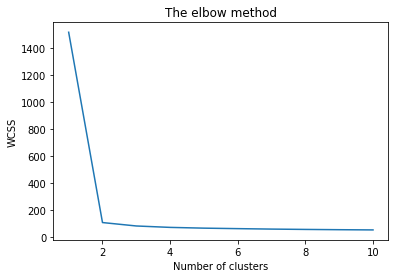

In [14]:
# We now plot the WCSS obtained 

# WCSS or within-cluster sum of squares is a measure of 
# how internally coherent the clusters are K-Means tries to minimize this criterion

plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Inference : 
# In the elbow graph, we look for the points where the drop falls and the line smoothens out
# In the above graph, this happens for k=2. 
# Another way of understanding this is that we note the point at which the WCSS is less 
# and try to find the number of clusters for our dataset. 
# We see that at the number of clusters = 2, WCSS is less than 100, which is good for us. 
# So we take k =2.
# We will check Silhouette Coefficient also for 2 and 3 Clusters respectively

In [15]:
# Running K-Means Model

# We now run K-Means clustering for obtaining a 2 cluster solution.
cluster_Kmeans = KMeans(n_clusters=2)
model_kmeans = cluster_Kmeans.fit(data_normalized)
pred_kmeans = model_kmeans.labels_
# print(pred_kmeans)

# Frequency count of the Output clusters
unique, counts = np.unique(pred_kmeans, return_counts=True)
dict(zip(unique, counts))

{0: 41939, 1: 2580}

In [16]:
# Frequency count of the Output clusters
unique, counts = np.unique(pred_kmeans, return_counts=True)
print('K Means Output Cluster Frequency')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 2 Clusters')
print(silhouette_score(data_normalized,pred_kmeans))
print("\n")

# In the above output we got value labels: ‘0’, ‘1’

# Inference :   
# Silhouette Score = 0.91 which is great (should be tend to 1)

K Means Output Cluster Frequency
{0: 41939, 1: 2580}
Silhouette Score for 2 Clusters
0.9263668833516382




In [27]:
# If we take 4 Cluster to Check Silhouetter Score
cluster_Kmeans = KMeans(n_clusters=3)
model_kmeans = cluster_Kmeans.fit(data_normalized)
labels_1 = model_kmeans.labels_
print("Silhouette Score for 3 Cluster")
print(silhouette_score(data_normalized,labels_1))

# Inference : 
# As we can observe Score is 0.29 (decrease so reject 3 Cluster)
# Optimal number of cluster=2 as its silhouette score is greater than that of 3 clusters

Silhouette Score for 3 Cluster
0.29355198034137153


#### Hierarchial Clustering

In [21]:
# Hierarchical Clustering 

# Agglomerative Clustering which is a method of clustering 
# which builds a hierarchy of clusters by merging together small clusters

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

# Importing Libraries

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [ ]:
# Plotting of Dendrogram

# We make use of dendrogram to decide the number of clusters required for our dataset
# A dendrogram is a tree diagram which illustrates the arrangement of clusters.
import scipy.cluster.hierarchy as sch
import os
# We finally plot a Dendrogram 
# which helps us in deciding what the threshold values should be for the clustering algorithm
# Basically, we decide the number of clusters by using this dendrogram.
path = f"plots-similarity"
if not os.path.exists(path):
    # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
    # Create a new directory
    os.makedirs(path)
    print(f"{path} directory is created")
Z = sch.linkage(data_normalized, method = 'median')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the data')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (median).pdf", dpi = 150)
plt.show()

In [ ]:
# Single Linkage - Nearest Point

Z = sch.linkage(data_normalized, method = 'single')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the data')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (single linkage - nearest point).pdf", dpi = 150)
plt.show()

In [ ]:
# Complete Linkage - Farthest Point 

Z = sch.linkage(iris_X_1, method = 'complete')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the dataset iris)')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (complete linkage - farthest point).pdf", dpi = 150)
plt.show()

In [ ]:
# Average Linkage - Average Distance between all points

Z = sch.linkage(iris_X_1, method = 'average')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the dataset iris)')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (average linkage).pdf", dpi = 150)
plt.show()

In [22]:
# Building an Agglomerative Clustering Model
# Initialise Model
# We analyse the above-created dendrogram 
# decide that we will be making 2 clusters for this data

cluster_H = AgglomerativeClustering(n_clusters=2)
cluster_H

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [ ]:
# Fitting Model
# After building Agglomerative clustering, we will fit our data 
# Note that only the independent variables from the data 
# are taken into account for the purpose of clustering

model_clt = cluster_H.fit(data_normalized)
model_clt

In [ ]:
# Predicting Output Class

print('Output Clusters are')
pred1 = model_clt.labels_
print(pred1)
# Frequency count of the Output clusters
unique, counts = np.unique(pred1, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
print('Hierarchical Clustering Output Cluster')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 2 Clusters')
print(silhouette_score(data_normalized,pred1))
print('\n')



#### DBSCAN Clustering

In [6]:
# DBSCAN

# Density-based spatial clustering of applications with noise, or DBSCAN 
# It is a popular clustering algorithm used as a replacement for k-means clustering
# To run it doesn’t require an input for the number of clusters 
# But DBSCAN does need to tune two other parameters
# 'eps' parameter is the maximum distance between two data points 
# to be considered in the same neighborhood. 
# 'min_samples' parameter is the minimum amount of data points 
# in a neighborhood to be considered a cluster

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

from sklearn.cluster import DBSCAN

In [7]:
# DBSCAN Clustering

# Declaring Model
clt_DB = DBSCAN()

# By Default Parameters in dbscan
clt_DB

# Inference :
# By Default 
# eps = 0.5, if we increase this size of cluster will increase
# distance metric = euclidean
# min_samples = 5

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [ ]:
# Fitting the model
model_dbscan = clt_DB.fit(data_normalized)
pred_dbscan = model_dbscan.labels_
print("DBScan Output Cluster v1")
# print(pred_dbscan)


In [ ]:
#Frequency count of the Output clusters
unique, counts = np.unique(pred_dbscan, return_counts=True)
freq_1 = dict(zip(unique, counts))
print("Frequency of DBScan Output Cluster v1")
print(freq_1)

In [27]:
# Optimize value of eps through Elbow Method

# eps is the maximum distance between two points. 
# It is this distance that the algorithm uses to decide on whether to club the two points together
# We will make use of the average distances of every point to its k nearest neighbors
# These k distances are then plotted in ascending order
# The point where you see an elbow like bend corresponds to the optimal *eps* value
# At that point, a sharp change in the distance occurs, and thus this point serves as a threshold

#! pip install rpy2
%reload_ext rpy2.ipython

In [ ]:
%%R
#install.packages('dbscan')
library(dbscan)
data(iris)
iris <- as.matrix(iris[,1:4])
dbscan::kNNdistplot(iris[, -c(5,4,3)], k =  4)

# Inference : 
# It looks like 0.42 is the optimal value for eps
abline(h = 0.42, lty = 2)

In [ ]:
# Now updating value of eps = 0.42

clt_DB = DBSCAN(eps=0.42)
model_dbscan = clt_DB.fit(data_normalized)
pred_dbscan = model_dbscan.labels_

# Frequency count of the Output clusters
unique, counts = np.unique(pred_dbscan, return_counts=True)
print('DBScan Output Cluster v2')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 2 Clusters')
print(silhouette_score(data_normalized,pred_dbscan))

print('\n')

# Inference : 
# In DBScan Cluster output Version 1,one class was missing i.e, no '2' class 
# But in DBScan New Output Cluster Version 2, distribution is much better
# So we should check and set parameters correctly i.e, eps
# All which are not classified in any Cluster are classified as OUTLIER
# Silhouette Score is 0.35 which is too less

#### Gaussian Mixture Model

In [15]:
# Gaussian Mixture Model

# Gaussian Mixture Models are probabilistic models
# It use the soft clustering approach for distributing the points in different clusters
# Gaussian Mixture Models (GMMs) assume that there are a certain number of Gaussian distributions, 
# and each of these distributions represent a cluster.
# Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together.

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

from sklearn.metrics import silhouette_score
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture



In [16]:
gmm = GaussianMixture(n_components=2)
model_gmm = gmm.fit(data_normalized)
model_gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [17]:
# GMM Output
labels = model_gmm.predict(data_normalized)
print("Gaussian Output Clusters")
# print(labels)
unique, counts = np.unique(labels, return_counts=True)
pred_2 = dict(zip(unique, counts))
print("Frequency of Gaussian Output Cluster")
print(pred_2)

Gaussian Output Clusters
Frequency of Gaussian Output Cluster
{0: 41935, 1: 2584}


In [19]:
# Frequency count of the Output clusters
unique, counts = np.unique(labels, return_counts=True)
print('GaussianMixture Output Cluster Frequency')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 2 Clusters')
print(silhouette_score(data_normalized,labels))
print('\n')

GaussianMixture Output Cluster Frequency
{0: 41935, 1: 2584}
Silhouette Score for 2 Clusters
0.9263142588077031


